In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
import sympy as sp
import scipy.stats
%matplotlib inline


In [2]:
ni = 18
nb = 9

In [3]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')
length_scale = 0.05
k = sp.exp(-((x_1-y_1)**2+(x_2-y_2)**2) / (2*length_scale**2))
A = lambda f: sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)
Abar = lambda f: sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)
B = lambda f: f
Bbar = lambda f: f
symbols = [[x_1, x_2], [y_1, y_2]]

# interior observations: sin(x)*sin(y)
x_interior, y_interior = np.mgrid[0.1:0.9:ni*1j, 0.1:0.9:ni*1j]
interior = np.c_[x_interior.ravel(), y_interior.ravel()]
exterior = np.r_[
    np.c_[np.linspace(0.1,0.9,nb), np.zeros(nb)], 
    np.c_[np.linspace(0.1,0.9,nb), np.ones(nb)],
    np.c_[np.zeros(nb), np.linspace(0.1,0.9,nb)],
    np.c_[np.ones(nb), np.linspace(0.1,0.9,nb)]
]

interior_obs = np.sin(2*np.pi*interior[:,0]) + np.sin(2*np.pi*interior[:,1])
exterior_obs = np.r_[
    np.zeros(nb*2),
    np.zeros(nb*2)
]

print interior.shape, interior_obs.shape
print exterior.shape, exterior_obs.shape
#%lprun -f bayesian_pdes.collocation.calc_LLbar posterior = bayesian_pdes.collocate([A, B], [Abar, Bbar], k, symbols, [(interior, interior_obs), (exterior, exterior_obs)])

(324, 2) (324,)
(36, 2) (36,)


In [4]:

def substitute(operators, dic):
    """
    Given an array of operator functionals, compose with the substitution functional specified by dic and return
    a new functional.
    """
    def __subs_op(o, dic):
        return lambda f: o(f).subs(dic)
    return [__subs_op(o, dic) for o in operators]


In [52]:
# set up the Allen-Cahn system
d = sp.Symbol('delta')
#d = 0.04
n_pts = 11

A_1 = lambda f: -d*(sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)) - 1./d * f
A_1_bar = lambda f: -d*(sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)) - 1./d * f
Identity = lambda f: f
B = Identity

ops = [A_1, Identity, B]
ops_bar = [A_1_bar, Identity, B]

# for now collocate on a basic grid (this is not efficient)
x, y = np.mgrid[0:1:n_pts*1j, 0:1:n_pts*1j]
x = x.ravel(); y = y.ravel()

on_bdy = (x == 0.) | (x == 1.) | (y == 0.) | (y == 1.)

collocate_interior = np.c_[x[~on_bdy], y[~on_bdy]]

collocate_boundary = np.c_[x[on_bdy], y[on_bdy]]

# define what the RHS of the system looks like
def rhs(locations):
    return np.zeros(location.shape[0])

# and on the boundary...
def boundary_rhs(locations):
    ret = np.empty(locations.shape[0])
    # impose condition on the y boundary
    y_bdy = (locations[:,1] == 1) | (locations[:,1] == 0)
    ret[y_bdy] = -1
    # impose condition on the x boundary
    x_bdy = (locations[:,0] == 1) | (locations[:,0] == 0)
    ret[x_bdy] = 1
    
    if np.any(~(x_bdy | y_bdy)):
        missing = locations[~(x_bdy | y_bdy), :]
        raise Exception("Some boundary observations don't appear to be on the boundary: {}".format(missing))
    return ret

boundary_obs = boundary_rhs(collocate_boundary)

In [53]:
def cube_root(arr):
    arr = np.asarray(arr)
    ret = np.empty_like(arr)
    ret[arr >= 0] = arr[arr > 0]**(1./3)
    ret[arr < 0] = - np.abs(arr[arr < 0])**(1./3)
    return ret

# Calculation of Importance Distn

In [54]:
from deflation.deflation import ForwardProblem
from deflation.petscsnessolver import PetscSnesSolver
import dolfin
from dolfin import dx
import math
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [55]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [56]:
import sys
args = [sys.argv[0]] + """
                       --petsc.snes_max_it 200
                       --petsc.snes_monitor
                       --petsc.snes_converged_reason
                       --petsc.snes_stol 0.0
                       --petsc.snes_rtol 0.0
                       --petsc.snes_type newtonls
                       --petsc.snes_linesearch_type basic

                       --petsc.ksp_type gmres
                       --petsc.ksp_rtol 1.0e-12
                       --petsc.ksp_atol 1.0e-12

                       --petsc.inner_pc_type lu
                       """.split()
dolfin.parameters.parse(argv=args)

In [74]:
def find_solutions(delta, mesh_points, max_solutions=3, stop_on_divergence=False, plot_solutions=False):
    mesh = dolfin.UnitSquareMesh(mesh_points, mesh_points)
    size = dolfin.MPI.size(dolfin.mpi_comm_world())
    if size > 1:
        nrefine = math.log(size, 4)
        if int(nrefine) != nrefine:
            print "Need to have processors a power of 4, as each refinement multiplies work by 4"
            assert False

        for i in range(int(nrefine) + 3):
            mesh = dolfin.refine(mesh, redistribute=False)

    V = dolfin.FunctionSpace(mesh, "CG", 1)
    Vdim = V.dim()
    #if dolfin.MPI.rank(dolfin.mpi_comm_world()) == 0:
    #    print "Degrees of freedom: ", Vdim
    #    print "Degrees of freedom per core: ", Vdim/float(size)

    delta = dolfin.Constant(delta)

    u = dolfin.Function(V)

    v = dolfin.TestFunction(V)
    F = delta * dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dx + 1.0/delta * dolfin.inner(v, u**3 - u)*dx

    bcs = [dolfin.DirichletBC(V, +1.0, "x[0] == 0.0 || x[0] == 1"),
           dolfin.DirichletBC(V, -1.0, "x[1] == 0.0 || x[1] == 1")]

    power = 1
    shift = 0.1
    problem = ForwardProblem(F, V, u, bcs, power=power, shift=shift)
    solver = PetscSnesSolver()

    roots = []
    natol = 1.0e-8

    for i in xrange(max_solutions):
        dolfin.PETScOptions.set("snes_atol", natol)
        try:
            solver.solve(problem, u.vector())
        except Exception as ex:
            if stop_on_divergence:
                break
            else:
                raise
            
        roots.append(dolfin.Function(u, name="Solution"))

        if plot_solutions:
            plt.figure()
            plot(roots[-1])
            plt.colorbar()
            plt.show()

        u.assign(dolfin.Constant(0))
        problem.deflate(roots[-1])
        if shift > 0:
            natol *= shift
    return roots

In [75]:
def compute_latent(points, delta, solutions):
    # it is most convenient to compute the latent variables as the cube of the values at the points (i.e. at A_2),
    # since this means we don't have to fuss about with gradients.
    res = np.empty((points.shape[0], len(solutions)))
    for i in range(len(solutions)):
        res[:,i] = np.vectorize(solutions[i])(points[:,0], points[:,1])
    return -res**3 / delta

In [77]:
counts = {}
for delta in np.linspace(0.03, 0.2):
    solutions = find_solutions(delta, 100, max_solutions=5, stop_on_divergence=True, plot_solutions=False)
    print 'Delta={}, {} solutions'.format(delta, len(solutions))
    counts[delta] = len(solutions)

Delta=0.03, 2 solutions
Delta=0.0334693877551, 2 solutions
Delta=0.0369387755102, 3 solutions
Delta=0.0404081632653, 3 solutions
Delta=0.0438775510204, 3 solutions
Delta=0.0473469387755, 3 solutions
Delta=0.0508163265306, 3 solutions
Delta=0.0542857142857, 3 solutions
Delta=0.0577551020408, 3 solutions
Delta=0.0612244897959, 3 solutions
Delta=0.064693877551, 3 solutions
Delta=0.0681632653061, 3 solutions
Delta=0.0716326530612, 3 solutions
Delta=0.0751020408163, 3 solutions
Delta=0.0785714285714, 3 solutions
Delta=0.0820408163265, 3 solutions
Delta=0.0855102040816, 3 solutions
Delta=0.0889795918367, 3 solutions
Delta=0.0924489795918, 3 solutions
Delta=0.0959183673469, 3 solutions
Delta=0.099387755102, 3 solutions
Delta=0.102857142857, 3 solutions
Delta=0.106326530612, 3 solutions
Delta=0.109795918367, 2 solutions
Delta=0.113265306122, 3 solutions
Delta=0.116734693878, 3 solutions
Delta=0.120204081633, 3 solutions
Delta=0.123673469388, 3 solutions
Delta=0.127142857143, 2 solutions
Delta=

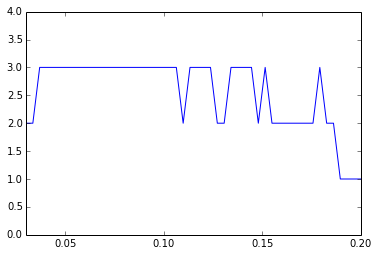

In [85]:
deltas, values = np.array(counts.keys()), np.array(counts.values())
order = np.argsort(deltas)
plt.plot(deltas[order], values[order])
plt.ylim(0,4);
plt.xlim(deltas.min(), deltas.max());

In [87]:
delta = 0.04
solutions = find_solutions(delta, 100, max_solutions=3, stop_on_divergence=True, plot_solutions=False)

A sensible range looks like $\delta \in [0.35, 1]$. It looks (however) as though while it becomes difficult to find solutions after this point, the three-solution regime is not broken until closer to $\delta=0.2$

In [88]:
z = compute_latent(collocate_interior, delta, solutions)

In [89]:
def collocate_latent(z, delta):
    obs = [
        (collocate_interior, z),
        (collocate_interior, cube_root(-delta*z)),
        (collocate_boundary, boundary_obs)
    ]
    
    ops_subs = substitute(ops, {d: delta})
    ops_bar_subs = substitute(ops_bar, {d: delta})
    #ops_subs = ops
    #ops_bar_subs = ops_bar
    
    posterior = bayesian_pdes.collocate(ops_subs, ops_bar_subs, k, symbols, obs)
    
    return posterior

In [90]:
def plot_mean(locations, mu):
    print locations.shape, mu.shape
    size = int(np.sqrt(locations.shape[0]))
    shape = (size, size)
    plt.contourf(locations[:,0].reshape(shape), locations[:,1].reshape(shape), mu.reshape(shape))

# Sampling from the LV distribution

In [91]:
def sample_latent(solutions, delta, test_points, n_samples=5, rho=1.0, debug=False):
    z = compute_latent(collocate_interior, delta, solutions)
    
    # now we sample from a mixture of solutions
    # let's first pretend that we know the solution and sample from it
    
    for i in xrange(z.shape[1]):
        plt.figure(figsize=(5*n_samples,5))
        this_z = z[:,i]
        for j in xrange(n_samples):
            dist = scipy.stats.multivariate_normal(this_z, rho)
            z_star = dist.rvs()
            
            if debug:
                start = time.time()
            posterior = collocate_latent(z_star, delta)
            
            if debug:
                print 'Generation of posterior took {}'.format(time.time() - start)
                start = time.time()
            mu, Sigma = posterior(test_points)
            if debug:
                print 'Evaluation of posterior took {}'.format(time.time() - start)
                start = time.time()
            plt.subplot(1,n_samples, j+1)

            plot_mean(test_points, mu)
            plt.colorbar()

In [92]:
test_x, test_y = np.mgrid[0:1:21j, 0:1:21j]
test = np.c_[test_x.ravel(), test_y.ravel()]

(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)
(441, 2) (441,)


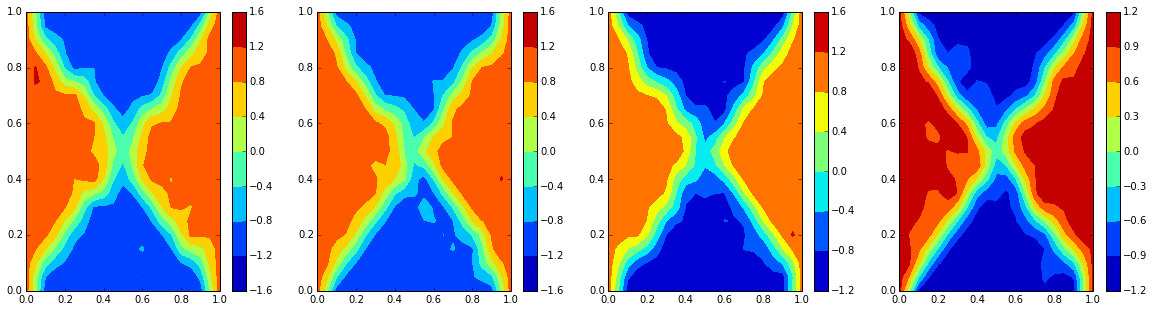

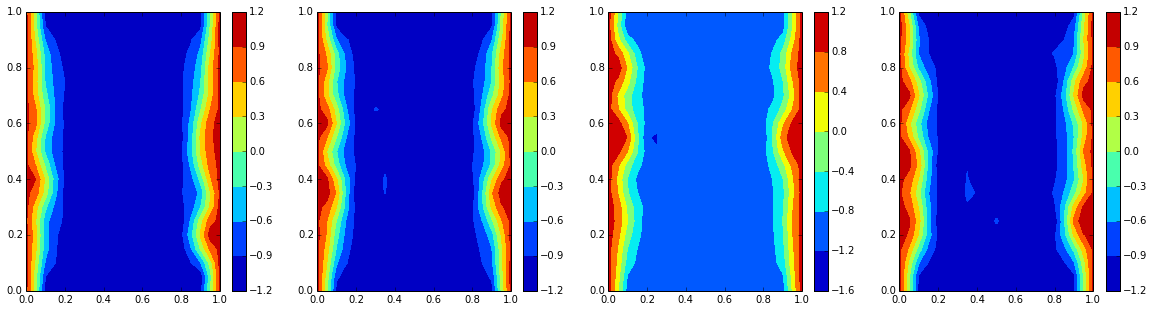

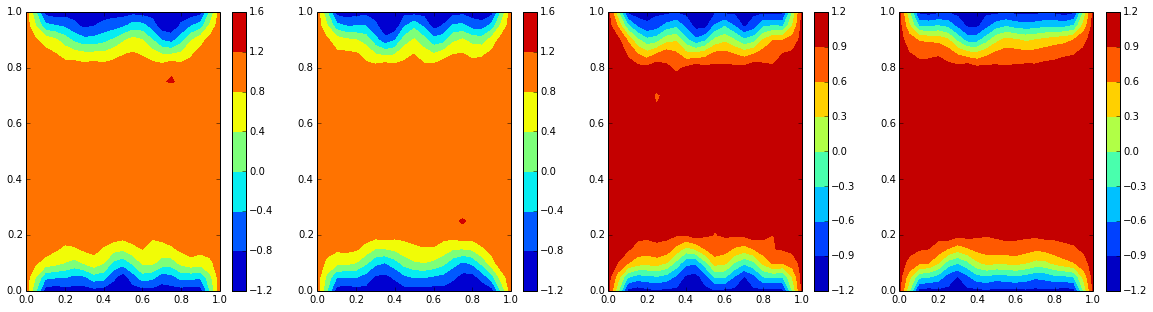

In [93]:
sample_latent(solutions, delta, test, n_samples=4)

# Calculation of PN Probability

In [36]:
def log_p_pn(true_obs, posterior, sigma, debug=False, plot=False):
    """
    true_obs: Tuple of observation locations and observation values for the true solution u
    delta: The current value of the parameter delta
    z: The current value of the latent variable z
    sigma: Allowed observation error in the Gaussian likelihood.
    returns: The PN probability p(y | delta)
    """
    true_locations, y = true_obs
    mu, Sigma = posterior(true_locations)
    if plot:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plot_mean(true_locations, mu)
        plt.colorbar()
        
        plt.subplot(122)
        plt.colorbar(plt.imshow(Sigma, interpolation=None))
        plt.show()
        
    
    error_mat = np.eye(mu.shape[0])*sigma**2
    Sigma_plus_error = Sigma + error_mat
    #Sigma_plus_error_inv = np.linalg.inv(Sigma_plus_error)
    
    #exponent = -0.5 * (y - mu).T.dot(Sigma_plus_error_inv).dot(y - mu)
    #assert type(exponent) is np.float64, "Exponent is of the wrong type, expected a float but was {}.".format(type(exponent))
    #fractional = np.linalg.det(2*np.pi*Sigma_plus_error)
    
    if debug:
        print 'True | Mean'
        print np.c_[y, mu]
        print 'Average abs. error: {}'.format(np.mean(np.abs(y-mu)))
        print 'Exponent: {} Fractional: {}'.format(exponent, fractional)
    
    return scipy.stats.multivariate_normal.logpdf(y, mean=mu, cov=Sigma_plus_error)
    #return 1./np.sqrt(fractional) * np.exp(exponent)

In [39]:
n_true_points = 25

tmp = np.vectorize(solutions[0])(collocate_interior[:,0], collocate_interior[:,1])
true_obs = (collocate_interior, tmp)

(81, 2) (81,)


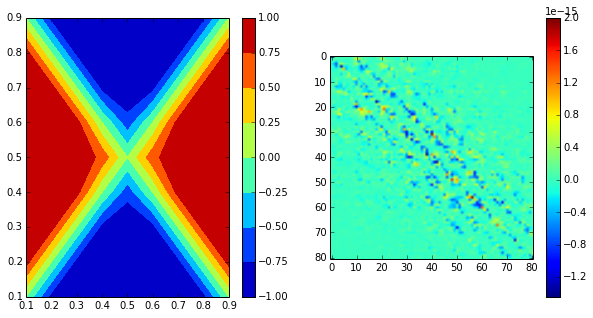

298.58476387546295

In [40]:
z = compute_latent(collocate_interior, 0.04, solutions)
posterior = collocate_latent(z[:,0], 0.04)
log_p_pn(true_obs, posterior, 0.01, debug=False, plot=True)

In [42]:
def p_pn_estimate(true_obs, delta, sigma, rho, n_samples, debug=False):
    # todo: need to compute solutions here as they vary with delta
    z = compute_latent(collocate_interior, delta, solutions)
    w = 1. / len(solutions) * np.ones(len(solutions))  # equal weighting for each solution
    w_cumulative = w.cumsum()
    estimates = np.empty(n_samples)
    # nb this is just an uninformative prior for now...
    log_prior = lambda z: 0.
    for i in xrange(n_samples):
        mixture_ix = np.argwhere(np.random.uniform() < w_cumulative).min()
        if debug:
            print 'Iteration {}, mixture {}'.format(i, mixture_ix)
        dist = scipy.stats.multivariate_normal(z[:, mixture_ix], rho)
        z_star = dist.rvs()
        log_r = np.log(w[mixture_ix]) + dist.logpdf(z_star)
        
        posterior = collocate_latent(z_star, delta)
        log_pn_proba = log_p_pn(true_obs, posterior, sigma)
        
        estimates[i] = log_prior(z) - log_r + log_pn_proba
        if debug:
            print 'Log-PN Proba: {} Log-r: {} Log-Estimate: {}'.format(log_pn_proba, r, estimates[i])
    #if debug:
    #    print estimates
    return np.exp(estimates)

In [49]:
estimates = p_pn_estimate(true_obs, 0.04, 0.1, 5.0, 100, debug=True)

Iteration 0, mixture 0
Log-PN Proba: -32.818001702 Log-r: -181.826075664 Log-Estimate: 149.008073962
Iteration 1, mixture 2
Log-PN Proba: -4718.15239486 Log-r: -180.292629059 Log-Estimate: -4537.8597658
Iteration 2, mixture 2
Log-PN Proba: -4465.81045368 Log-r: -180.456205991 Log-Estimate: -4285.35424769
Iteration 3, mixture 2
Log-PN Proba: -4516.09421488 Log-r: -179.842010884 Log-Estimate: -4336.25220399
Iteration 4, mixture 1
Log-PN Proba: -4626.38917874 Log-r: -188.748739451 Log-Estimate: -4437.64043929
Iteration 5, mixture 0
Log-PN Proba: -33.4444201583 Log-r: -184.572793807 Log-Estimate: 151.128373649
Iteration 6, mixture 0
Log-PN Proba: -35.0882453186 Log-r: -178.568261951 Log-Estimate: 143.480016632
Iteration 7, mixture 2
Log-PN Proba: -4508.2464434 Log-r: -183.203940843 Log-Estimate: -4325.04250256
Iteration 8, mixture 0
Log-PN Proba: -16.4203738316 Log-r: -173.084586397 Log-Estimate: 156.664212565
Iteration 9, mixture 2
Log-PN Proba: -4765.67699118 Log-r: -171.770209225 Log-Es

In [50]:
print estimates

[  5.16873517e+64   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   4.30743502e+65   2.05390091e+62   0.00000000e+00
   1.09245367e+68   0.00000000e+00   0.00000000e+00   2.25999360e+77
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.08125693e+60
   0.00000000e+00   0.00000000e+00   9.22317069e+54   0.00000000e+00
   2.01620845e+62   0.00000000e+00   0.00000000e+00   6.08871379e+64
   6.37930371e+77   0.00000000e+00   0.00000000e+00   1.20085116e+58
   0.00000000e+00   8.99462656e+64   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   7.83818190e+73   2.80429725e+64
   0.00000000e+00   5.21389695e+73   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   2.80738324e+63
   0.00000000e+00   1.69362630e+77